# NLP Product Classifier

## 1. Introduction

As part of a Product initiative, the Data Science team is asked to develop a solution to properly classify listings that fall between two categories: **0-Cellphones** and **1-Computers**. We could use a lot of data from existing items (title, description, images, price, and other fields and metadata), but as an MVP, we decide to implement a ML solution based only on text (the items title), and frame it as a **binary classification problem**.

We then build a dataset by querying from the Data Warehouse a sample of 1500 items from these two categories, with their titles (in lower case) and their categories (selected by the users when uploaded). This dataset can be found in the attached file `data.json`.

In the next sections we will tackle the problem with two different approaches to assess the feasibility of the challenge.

## 2. Loading the dataset

First, we begin by loading the dataset. If the file `data.json` is in the same location as this notebook (or a suitable path), you should be able to run the next two cells just fine. Otherwise, if you face any issue, you can copy and paste the data in the `else` statement below.

In [15]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [93]:
# SOME HELPERS
def conf_matrix(y_true, y_pred, labels, norm='columns'):
    confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['true label'], colnames=['predictions'], normalize=norm).round(3)
    if norm:
        confusion_matrix = confusion_matrix*100
        confusion_matrix[confusion_matrix < 1] = 0
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues, square=True, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.show()
    
labels = ["cellphones","computers"]
label_mapper = {0: "cellphones", 1: "computers"}
green = "#067242"

In [17]:
data_file = 'data.json'

if os.path.exists(data_file):
    print("Loading data from file...")
    with open(data_file) as f:
        data = json.load(f)
        
else:
    print("Loading data from string...")
    # replace next lines with data if needed
    data = json.loads("""[
      {"title": "xgody smartphone (nuevo)","category": "cellphones","category_num": 0},
      {"title": "kindle paperwhite segunda generacion","category": "computers","category_num": 1},
    ]""")

Loading data from file...


In [18]:
df = pd.DataFrame.from_records(data)
print("DF shape:", df.shape)
df.head()

DF shape: (1500, 3)


,title,category,category_num
0,xgody smartphone (nuevo),cellphones,0
1,kindle paperwhite segunda generacion,computers,1
2,amplificador de antena nuevo,cellphones,0
3,volante logitech g27,computers,1
4,fitbit alta hr,cellphones,0


#### QUESTION 1: Plot the class distribution of the dataset. What we should consider in terms of balancing?

,records,%
computers,838,0.558667
cellphones,662,0.441333


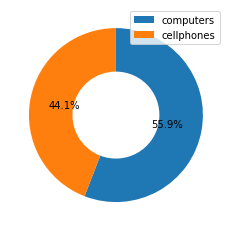

In [19]:
# CODE ANSWER:
# Distribution dataframe creation
distribution = pd.DataFrame([])
distribution["records"] = df["category"].value_counts()
distribution["%"] =  distribution["records"]/len(df)
display(distribution)

# Distribution plot
plt.pie(distribution["records"],  wedgeprops=dict(width=0.50), startangle=90, counterclock=False, autopct='%1.1f%%')
plt.legend(distribution.index)
plt.show()

##### TEXT ANSWER
The dataset is quite balanced. There is some predominance on class "computers", around 10% (176 records) more than "cellphones".
The difference doesn't seem to be enough to consider imbalancing issues. 

## 3. Splitting the dataset

We proceed to split the dataset in two sets: train and test.

In [20]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(df["title"], df["category_num"], test_size=0.2, random_state=42)
print("Train size: {}".format(df_train.shape[0]))
print("Test size: {}".format(df_test.shape[0]))

Train size: 1200
Test size: 300


## 4. Training

As mentioned in the introduction, we will try to solve the problem with two different approaches.

### 4.1. Random Forest with word vectors

We build a TF-IDF vectorizer from the dataset...

In [49]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = stopwords.words("spanish")
vectorizer = TfidfVectorizer(max_features=500, stop_words=stopwords, min_df=3)
vectorizer.fit(df_train) # Better to fit with train set to keep more realistic results on test

X_train = vectorizer.transform(df_train)
X_test = vectorizer.transform(df_test)

[nltk_data] Downloading package stopwords to /home/marc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


And train a Random Forest model:

#### QUESTION 2: Train a RandomForest classifier with Scikit-learn.

              precision    recall  f1-score   support

  cellphones       0.88      0.87      0.88       532
   computers       0.90      0.91      0.90       668

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



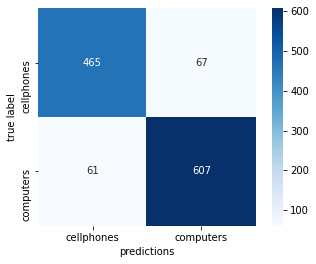

In [54]:
# CODE ANSWER:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

rdmforest = RandomForestClassifier(n_estimators=80, min_samples_split=100,min_samples_leaf=2, criterion="gini")
rdmforest.fit(X_train, y_train.values)
y_pred = rdmforest.predict(X_train)

print(classification_report(y_train, y_pred, target_names=labels))
conf_matrix(y_train, y_pred, labels, norm=False)

#### QUESTION 3: Assess the performance of this approach.

              precision    recall  f1-score   support

  cellphones       0.87      0.79      0.83       130
   computers       0.85      0.91      0.88       170

    accuracy                           0.86       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.86      0.86       300



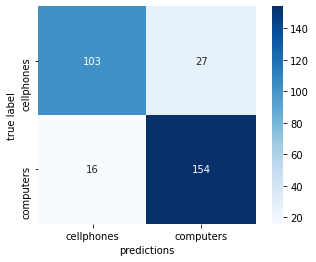

In [55]:
# CODE ANSWER:
y_pred = rdmforest.predict(X_test)

print(classification_report(y_test, y_pred, target_names=labels))
conf_matrix(y_test, y_pred, labels, norm=False)

#### TEXT ANSWER
- Training Phase

The resulting model classifies better computers than cellphones. We get 88% f1-score on cellphones, with similar precision-recall performance. Same happens with computers, but this time we get 90% f1-score, showing a good precision-recall balance as well. As we are in an almost balanced problem, accuracy is a good metric to get an idea of model overall performance, where we reach a 90% accuracy. The accuracy isn't high enough, but at least doesn't seem overfitted, let's see what happens on testing phase. If we check the confusion matrix we get see that ~120 records were misclassified.

- Testing Phase

The accuracy decreases to 86%. The worst metric is the "cellphone" recall (79%), that shows that some cell phones are being classified as a computer. 

### 4.2. Recurrent Neural Network (LSTM) with word embeddings

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Embedding, LSTM, Dense

In [62]:
max_words = 500
max_length = 10
embedding_dim = 50
batch_size = 32
num_epochs = 15

We begin by building a Keras word Tokenizer:

In [63]:
tokenizer = Tokenizer(num_words=max_words, oov_token=1)
tokenizer.fit_on_texts(df_train)

X_train = tokenizer.texts_to_sequences(df_train)
X_train = pad_sequences(X_train, maxlen=max_length)

X_test = tokenizer.texts_to_sequences(df_test)
X_test = pad_sequences(X_test, maxlen=max_length)

#### QUESTION 4: What is the parameter `oov_token=1` in the cell above? What is its purpose?

##### TEXT ANSWER:
oov_token stands for out of vocabulary tokens. This parameter allows to take into account words that aren't present in the pretrained corpus. As we are working on the user's text we will find misspelings and rare words, so it's a good practice to keep these words. In this case the words will be tokenized as "1".

We then train a simple RNN LSTM architecture:

In [64]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=50, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test)
)

Epoch 1/15
38/38 [==============================] - 3s 19ms/step - loss: 0.6852 - accuracy: 0.5300 - val_loss: 0.6389 - val_accuracy: 0.5867
Epoch 2/15
38/38 [==============================] - 0s 8ms/step - loss: 0.5941 - accuracy: 0.6806 - val_loss: 0.4612 - val_accuracy: 0.7867
Epoch 3/15
38/38 [==============================] - 0s 8ms/step - loss: 0.4101 - accuracy: 0.8217 - val_loss: 0.3549 - val_accuracy: 0.8567
Epoch 4/15
38/38 [==============================] - 0s 8ms/step - loss: 0.3247 - accuracy: 0.8725 - val_loss: 0.3196 - val_accuracy: 0.8567
Epoch 5/15
38/38 [==============================] - 0s 8ms/step - loss: 0.2905 - accuracy: 0.8854 - val_loss: 0.3163 - val_accuracy: 0.8600
Epoch 6/15
38/38 [==============================] - 0s 8ms/step - loss: 0.2802 - accuracy: 0.8873 - val_loss: 0.3053 - val_accuracy: 0.8800
Epoch 7/15
38/38 [==============================] - 0s 7ms/step - loss: 0.2595 - accuracy: 0.8907 - val_loss: 0.3093 - val_accuracy: 0.8633
Epoch 8/15
38/38 [=

And plot the training history:

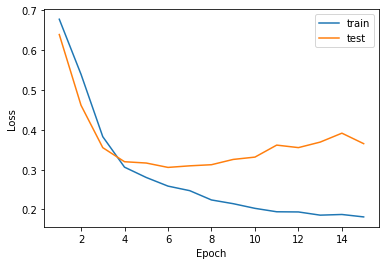

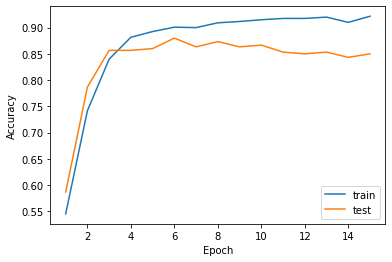

              precision    recall  f1-score   support

  cellphones       0.94      0.91      0.92       532
   computers       0.93      0.95      0.94       668

    accuracy                           0.93      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.93      0.93      0.93      1200



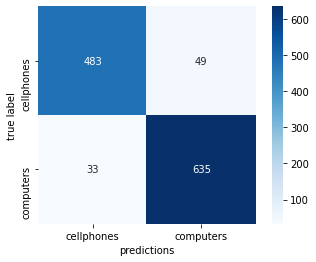

In [65]:
epochs = range(1, num_epochs+1)

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(epochs, history.history["loss"], label="train")
plt.plot(epochs, history.history["val_loss"], label="test")
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(epochs, history.history["accuracy"], label="train")
plt.plot(epochs, history.history["val_accuracy"], label="test")
plt.legend(loc='lower right')

plt.show()

y_pred = model.predict(X_train).round()
print(classification_report(y_train, y_pred.reshape(1,-1)[0], target_names=labels))
conf_matrix(y_train, y_pred.reshape(1,-1)[0], labels, norm=False)

#### QUESTION 5: What can you say about the training of this model?

##### TEXT ANSWER:
If we take a look on Accuracy and Loss plots we quickly see that the model is overfitting after epoch 6. We reach 88% accuracy on validation set at epoch 6, but for next iterations as the accuracy increases for the training set, decreases on the validation set. The solution is simple, we can train for only 6 epochs to get the model with best generalization. The callback early stopping is a good helper to avoid overfitting issues on keras models.

#### QUESTION 6: Assess the performance of this approach. How could you compare it to the first approach? In a follow-up meeting for this project you are asked to give an estimate of the performance we can expect to have with this model. How would you assess it?

              precision    recall  f1-score   support

  cellphones       0.87      0.77      0.82       130
   computers       0.84      0.91      0.87       170

    accuracy                           0.85       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.85      0.85       300



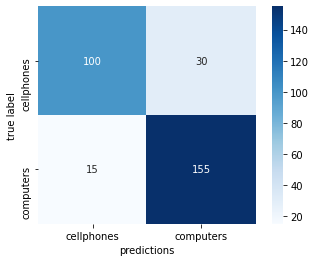

In [67]:
# CODE ANSWER:
y_pred = model.predict(X_test).round()
print(classification_report(y_test, y_pred.reshape(1,-1)[0], target_names=labels))
conf_matrix(y_test, y_pred.reshape(1,-1)[0], labels, norm=False)

##### TEXT ANSWER

For this overfitted model we get 85% accuracy on test set whichs is lower than the previous 86% with random forest algorithm. If we take a look into training history, we can how at epoch six we get up to 88% accuracy on test set. In any case, as we have a small dataset with short text sentences there is not need to use DL approaches. Embeddings + LSTM  takes advantage of word sequence relationships, but in this case the feature "title" is not long enough to be a better approach than a classic td-idf+ML solution. 

What I would suggest is to avoid using complex models and keep it simple with the first approach with some improvements. I would say that best accuracy is around less than 90% on test set because the human error on grown truth categories. With more records and features the embeddings+LSTM approach would be a powerful model which probably outperforms the ML approach.

#### QUESTION 7: Retrieve some examples of mistakes made by the model. What can you say about them?

In [68]:
# CODE ANSWER:
temp = pd.DataFrame([])
temp["title"] = df_test
temp["category"] = y_test
temp["prediction"] = y_pred
temp["category"] = temp["category"].replace(label_mapper)
temp["prediction"] = temp["prediction"].replace(label_mapper)
temp[temp["category"] != temp["prediction"]].sample(10)

,title,category,prediction
1385,apple tv 32gb full hd,computers,cellphones
1430,realismo económico,cellphones,computers
1146,xiaomi mi5s gama alta. batería nueva.,cellphones,computers
277,garmin vivosmart 4,cellphones,computers
1470,aire acondicional personal nuevo + regalo,cellphones,computers
999,samsung a7 2018,computers,cellphones
554,pantalla samsung,computers,cellphones
432,caja iphone 6nueva,computers,cellphones
462,funda iphone 7plus y 8 plus,computers,cellphones
1357,macbook pro retina 15 i7 16gb ram 500ssd,computers,cellphones


##### TEXT ANSWER

What stands out most is the existing errors on user classifying its own product. For example, however "caja iphone 6nueva" or "samsung a7 2018" are supposed to be in "cellphone" category, the user tagged them as "computer". What a would suggest is to manually check the dataset to correct the errors to have a reliable ground truth and train the models again.

The word "samsung" seems a problematic token, probably because is related with cell phones and computers.

#### QUESTION 8: Implement a function `get_prediction` to get, for any text input, the category given by the model, and test it with some of the mistakes above.

In [69]:
# ANSWER:
def get_prediction(text: str, vectorizer: Tokenizer, model: Sequential) -> str:
    """
    :param text: string containing the sentence to categorize 
    :param vectorizer: fitted keras tokenizer 
    :param model: fitted keras sequential model
    :return category: resulting category
    """
    labels = ["cellphones", "computers"]
    vectorized = vectorizer.texts_to_sequences([text])
    vectorized = pad_sequences(vectorized, maxlen=max_length)
    category = model.predict(vectorized).round()[0][0]
    category = labels[int(category)]
    return category

text = "samsung s10 pus (somos tienda física)"
print(f"{text} --> {get_prediction(text, tokenizer,  model)}")
text = "funda cargador iphone 4s"
print(f"{text} --> {get_prediction(text, tokenizer, model)}")
text = ""
print(f"{text} --> {get_prediction(text, tokenizer, model)}")

samsung s10 pus (somos tienda física) --> computers
funda cargador iphone 4s --> cellphones
 --> computers


##### 
It's interesting how the model works when there's no data. In this case, the model say "computers" if we don't have content, maybe because the higher presence of this class on the dataset.

## 5. Final Discussion

#### QUESTION 9: What could be the next iterations of this project? More precisely:

- **What would you change about the dataset used: information available, processing, etc?**
- **How would you improve any/both of the approaches above, or what would you make differently?**
- **Optionally, if you feel more confident using other libraries or architectures, or just think you can improve the current performance, feel free to give it a try! ;)**

##### TEXT ANSWER: What would you change about the dataset used: information available, processing, etc?
- More Data

First of all, gathering more records probably helps on training and evaluation steps. With the current dataset the model is not able to find better patterns because some relevant tech words have less than 3 repetitions. Having more data on evaluation phase will provide a better idea of how will perform on production.

- More features

Title usually has very relevant information about the product, but sometimes can be very short. I would suggest to start adding features as product description or hashtags.

Maybe the price could be useful combined with text info. In higher complex problems or products without much information an ensemble solution with an image classifier could be a powerful tool as well.

- Processing

I like to ask myself how I would solve the problem without ML so it could help to find interesting preprocessing methods. For example, we could manually create a dictionary of phone/computer brands or specific words to create a new binary feature that direcly relates title text with a category. For example: {"iphone": "cellphone"}

In terms of vectorizing there's lots of approaches, but I usually like to improve tf-idf doing some research as trying different n-grams combinations or tweaking other hyper-parameters. At first sight I wouldn't go for a word2vec approach since we have a lot of domain specific words that probably aren't present in word2vec corpus. 

If we have largest sentences we could use a NER algorithm to extract keywords, for example, brands or device type.

##### TEXT ANSWER: How would you improve any/both of the approaches above, or what would you make differently?
- ML approaches

I would add some steps like cross-validation and gridsearch to look for best hyper-parameter combination. Perhaps random forest it's easy to interpret, I would give a try to SGDClassifier to check if SVM or logistic regression performs better. 

- DL approaches: more data, CNN, transformers

With more records and richer features I would research on DL solution. I wouldn't make many changes to the current architecture, maybe play around with dropout or add one layer. I usually prefer to use succesfull archichetures from appers or pretrained models as transformers.

### 5.1 Data Analysis

To conclude, I've performed a small data analysis to understand better the data itself.

In [33]:
import unidecode

# REMOVE ACCENTS ON STOPWORDS
stopwords = [unidecode.unidecode(word) for word in stopwords]

Mean Word Occurrence: 8.788
Median Word Occurrence: 4.0


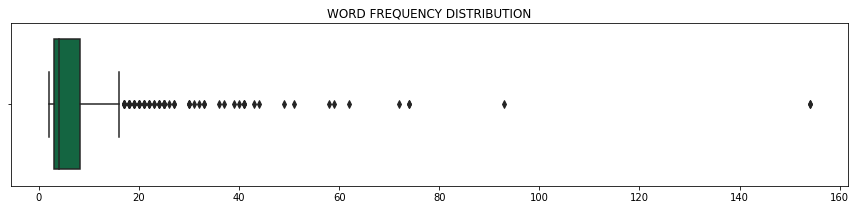

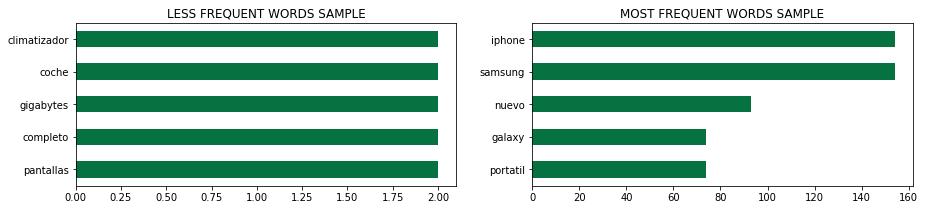

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
counter = CountVectorizer(max_features=500, stop_words=stopwords, strip_accents="unicode", lowercase=True)
df_counter = counter.fit_transform(df["title"])
df_counter = pd.DataFrame(df_counter.todense(), columns=counter.get_feature_names())
counter_abstract = df_counter.sum().sort_values()


print(f"Mean Word Occurrence: {counter_abstract.mean()}")
print(f"Median Word Occurrence: {counter_abstract.median()}")

plt.figure(figsize=(15,3))
sns.boxplot(x=counter_abstract, color="#067242")
plt.title("WORD FREQUENCY DISTRIBUTION")
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
counter_abstract.head().plot(kind="barh", color=green, ax=axes[0], title="LESS FREQUENT WORDS SAMPLE")
counter_abstract.tail().plot(kind="barh", color=green, ax=axes[1], title="MOST FREQUENT WORDS SAMPLE")
plt.show()

##### WORD FREQUENCY
- A lot of words appears only 2 times. 
- The word with more occurences is "iphone" followed by "samsung".

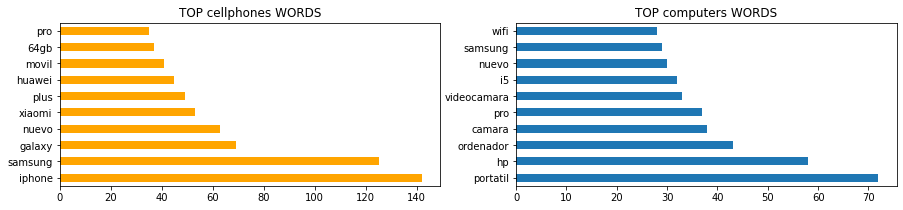

In [35]:
df_counter_with_categories = df_counter.join(pd.get_dummies(df["category"]))
coocurrence = df_counter_with_categories.T.dot(df_counter_with_categories)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))

category = "cellphones"
most_frequent_words = coocurrence[category].sort_values(ascending=False).iloc[1:11]
most_frequent_words.plot(kind="barh", color="orange", ax=axes[0], title=f"TOP {category} WORDS")

category = "computers"
most_frequent_words = coocurrence[category].sort_values(ascending=False).iloc[1:11]
most_frequent_words.plot(kind="barh", ax=axes[1], title=f"TOP {category} WORDS")
plt.show()

##### WORD OCCURENCES PER CLASS
- As expected, samsung appears on "computers" and "cellphones".
- The word "nuevo" is relevant in two categories but it's not informative. I would get rid of it for next iterations.

Mean Title Lenght: 3.0


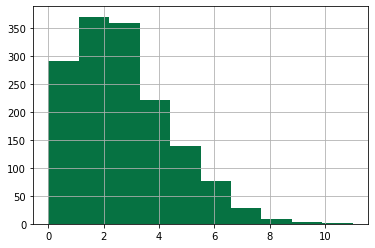

In [76]:
# TITLE LENGHT
title_len = df_counter.sum(1)
print(f"Mean Title Lenght: {title_len.mean().round()}")
title_len.hist(color=green)
plt.show()

##### TITLTE LENGTH
On the embedding model we have set max_length to 10, which is correct if we take a look on token distribution per product.

In [92]:
# RANDOM FOREST RELEVANCES
df_relevances = pd.DataFrame(rdmforest.feature_importances_, index=vectorizer.get_feature_names(), columns=["relevance"]).sort_values(by="relevance")
print("NOT RELEVANT WORDS")
print(list(df_relevances[df_relevances["relevance"] == 0].index))

print("\nLOW RELEVANT WORDS")
display(df_relevances[df_relevances["relevance"] > 0].head(10))

print("\nHIGH RELEVANT WORDS")
display(df_relevances[df_relevances["relevance"] > 0].tail(10))

NOT RELEVANT WORDS
['buen', '3gb', '500', 'pavilion', '750', 'a50', 'rom', 'ultrabook', 'tactil', 'ghz', 'silver', 'gamer', 'g6', 'dell', 'discreta', 'elitebook', 'mas', 'cam', '250', 'fotos', 'impoluto', 'real', '23', '2017', 'pulsera', '1080']

LOW RELEVANT WORDS


,relevance
compaq,0.000003
dv,0.000004
sata,0.000005
ddr4,0.000005
360,0.000006
17,0.000006
silla,0.000007
mac,0.000007
control,0.000007
benq,0.000008



HIGH RELEVANT WORDS


,relevance
plus,0.018175
vendo,0.018936
note,0.021560
teléfono,0.025945
xiaomi,0.032764
lg,0.034760
galaxy,0.037848
huawei,0.039003
samsung,0.062701
iphone,0.138893


##### RANDOM FOREST RELEVANCES

- There are some words that the model actually found irrelevant.
- Most informative words for the model are brands ("iphone", "samsung", "huawei",...)